While reading about transformers, I had questions about just how important LayerNorm was. Is it just normalizing the data, or does it change the network in a way similar to a positional encoding? How does it relate to feature representation and (poly)semanticity? Does "folding it in" to the subsequent (previous?) layer in a network make things more or less interpretable? How much better is it than BatchNorm for LLMs, and why? 

While looking at Conjecture's research, I came across this post (https://www.lesswrong.com/posts/jfG6vdJZCwTQmG7kb/re-examining-layernorm), and decided to go through their work to learn more about it. They even have a nice google colab to refer to for more details/ in case I got stuck.

Things I learned: 
-  LayerNorm can be used in place of the activation function  (indeed, it is pretty much a sigmoid activation function with some linear additions)
- The non-linearity can be understood geometrically, making the features fairly interpretable. 
- You can use this newfound geometric understanding to build intuition for more complicated networks with more layers
- How to create better looking plots (with the hope of eventually learning plotly)

First: Understanding the basics about layernorm. The nonlinear bit is just a normalization (sigmoid activation) with mean=0 and var = 1. The learned weights and biases are linear. (The linear bit can probably be folded into the next linear layer, for example). 

Text(0, 0.5, 'Core Nonlinearity of LayerNorm')

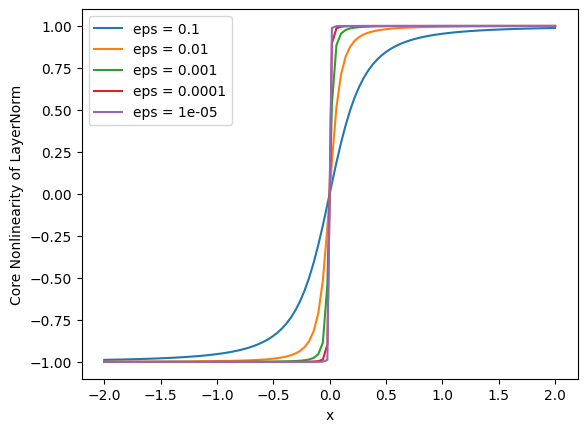

In [374]:
import torch as t
import matplotlib.pyplot as plt
import numpy as np 
from tqdm import tqdm
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def LN_nonlinearity(vec,eps=1e-5):
    sq_norm = t.sum(vec**2, dim = -1,keepdim=True)
    return vec/t.sqrt(sq_norm+eps)

#x is a list of 1 element vectors
x = t.linspace(-2,2,100).unsqueeze(1)
assert x.mean() < 10**-8
epsilons = [10**-i for i in range(1,6)]
for eps in epsilons:
    plt.plot(x, LN_nonlinearity(x,eps) )  
plt.legend([f"eps = {eps}" for eps in epsilons])
plt.xlabel("x")
plt.ylabel("Core Nonlinearity of LayerNorm")

The LayerNorm Activation function: 
- Centering: Subtracting the mean is like projecting out a dimension of the residual stream (why?). This can either be incredibly meaninful (if the gradients are too high) or could be meaningless? 
- A vector has variance 1 if it has length 1/\sqrt(n) (n the length of this vector. mean, variance are taken with respect to EACH vector. This makes sense since each vector has its own residual stream. )

In [338]:
## Affine transformation - Linear part
def affine(x, wts, b):
    return x*wts + b

def layer_norm_1(x, wts, b, eps= 1e-5):
    sub_mean = x - t.mean(x)
    n = x.shape[-1]
    #print(n)
    ## Multiply through with factor of n to rescale x -> sqrt(n0) (var 1)
    return affine(LN_nonlinearity(sub_mean,n*eps), np.sqrt(n)*wts, b)

def layer_norm(x, wts, b, eps=1e-5):
    x_mean = x.mean(dim=-1, keepdim=True)
    ##unbiased=False sets the 1/n convention of pytorch
    x_var = x.var(dim=-1, keepdim=True, unbiased=False)
    print(x.shape, x_var.shape, x_mean.shape)
    x_norm = (x-x_mean)/t.sqrt(x_var + eps)
    return affine(x_norm, wts, b)

### Test this function against pytorch's implementation of LayerNorm 
##### Does a decent job - The error comes from Pytorch's normalization convention (n isntead of n-1)
error = 0 
num_tests = 100
for i in range(num_tests):
    n = t.randint(1,2000, (1,)).item()
    x = t.rand(n)
    wts = t.rand(n)
    b = t.rand(n)
    eps = t.rand(1).item()
    assert x.shape == b.shape
    out = layer_norm_1(x, wts, b, eps)
    out_torch = t.nn.functional.layer_norm(x,(n,), wts, b, eps)
    error += t.linalg.vector_norm(out - out_torch, ord = 1).item()
print(f"error for warm-up LN implementation = {error/num_tests}")

for i in range(num_tests):
    n = t.randint(1,2000, (1,)).item()
    x = t.rand(n)
    wts = t.rand(n)
    b = t.rand(n)
    eps = t.rand(1).item()
    assert x.shape == b.shape
    out = layer_norm(x, wts, b, eps)
    out_torch = t.nn.functional.layer_norm(x,(n,), wts, b, eps)
    error += t.linalg.vector_norm(out - out_torch, ord = 1).item()
print(f"error for better LN implementation = {error/num_tests}")

## ... they are exactly the same! Why? 

error for warm-up LN implementation = 2.9362804198171944e-05
torch.Size([359]) torch.Size([1]) torch.Size([1])
torch.Size([90]) torch.Size([1]) torch.Size([1])
torch.Size([1066]) torch.Size([1]) torch.Size([1])
torch.Size([1049]) torch.Size([1]) torch.Size([1])
torch.Size([1703]) torch.Size([1]) torch.Size([1])
torch.Size([1135]) torch.Size([1]) torch.Size([1])
torch.Size([1243]) torch.Size([1]) torch.Size([1])
torch.Size([212]) torch.Size([1]) torch.Size([1])
torch.Size([393]) torch.Size([1]) torch.Size([1])
torch.Size([1775]) torch.Size([1]) torch.Size([1])
torch.Size([1848]) torch.Size([1]) torch.Size([1])
torch.Size([913]) torch.Size([1]) torch.Size([1])
torch.Size([1173]) torch.Size([1]) torch.Size([1])
torch.Size([257]) torch.Size([1]) torch.Size([1])
torch.Size([903]) torch.Size([1]) torch.Size([1])
torch.Size([547]) torch.Size([1]) torch.Size([1])
torch.Size([1255]) torch.Size([1]) torch.Size([1])
torch.Size([380]) torch.Size([1]) torch.Size([1])
torch.Size([1207]) torch.Size([

Stretching and Folding: Understanding the geometric consequences of acting with the LayerNorm activation function 
- The activation is typically composed with affine transformations, which apply rotations, stretching (scaling) and translations. 
- Is this really understanding the nonlinearity, or just the linear part? Yes, since you see what happens to simple transformations as they pass through the non-linearity ... they are normalized so that there distribution changes in a predictable way 

One-dimensional stretch 
- compose the nonlinear LN activation with a simple scaling x -> alphax
- plt this on an input data set that is S^1


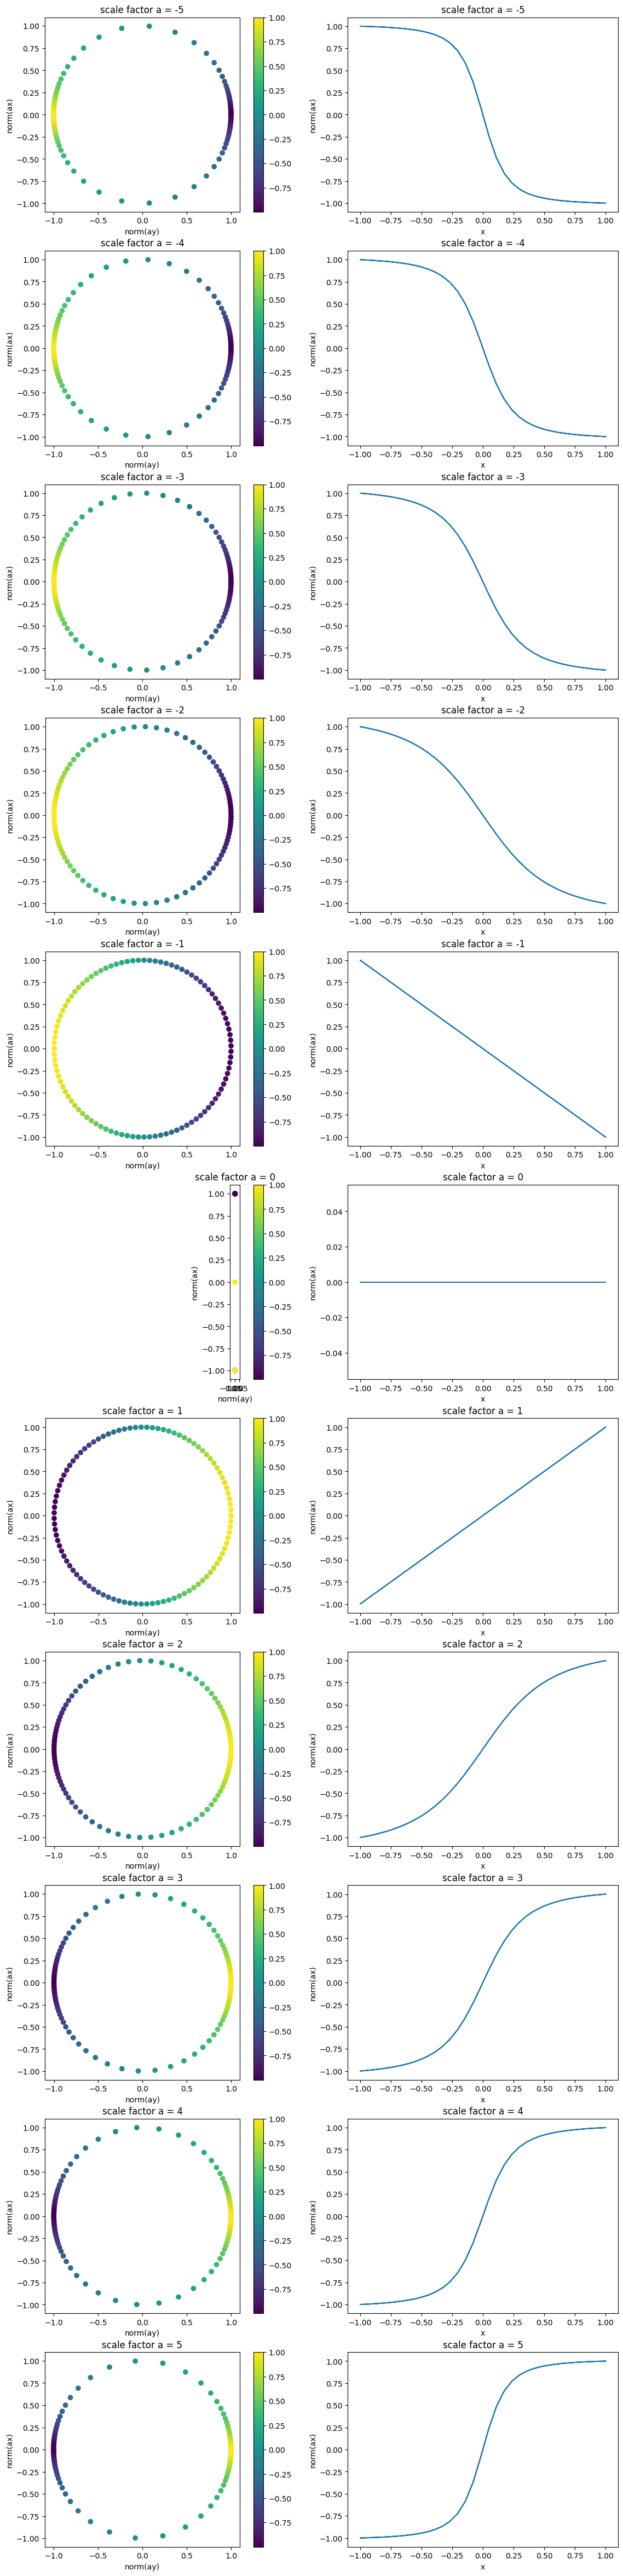

In [434]:
#number of data points 
n_points = 100

# #
def uniform_circle_data(n):
    theta = t.linspace(0,2*t.pi, n)
    return t.stack((t.cos(theta), t.sin(theta)), dim=1)

data = uniform_circle_data(n_points).unsqueeze(0)

# Use the default value for eps
### Apply transformation to only x dimension
#### normalization via LN_nonlinearity should keep all points on unit circle
### I think they may have their x and y axes switched, unless I'm missing something (also possible)

def warp(data, scale, trans, eps=1e-5):
    transformed_data = (t.FloatTensor([scale,1])*data.squeeze() + t.FloatTensor([trans,0])).unsqueeze(0)
    return LN_nonlinearity(transformed_data)
scalings = t.arange(-5,6)

fig, ax = plt.subplots(len(scalings),2, figsize=(14,60))
for i, scale in enumerate(scalings):
    stretch_func = warp(data, scale,0).squeeze()
    test = ax[i][0].scatter(stretch_func[:,0], stretch_func[:,1], c=data.squeeze()[...,0])
    ax[i][0].set_aspect('equal')
    ax[i][1].plot(data[0,:,0],stretch_func[:,0])
    ax[i][0].set_title(f"scale factor a = {scale}")
    ax[i][1].set_title(f"scale factor a = {scale}")
    ax[i][0].set(xlabel="norm(ay)", ylabel = "norm(ax)")
    ax[i][1].set(xlabel="x", ylabel = "norm(ax)")
    fig.colorbar(test)
    #ax.colorbar()
    #fig.colorbar(data.squeeze()[...,0], ax=ax[i][0])



In [408]:

#- They use a linear interpolation approach to rescale everything, I just did the scaling by hand



In [396]:
# ## bound on alpha 
# bound = 2
# # vectorize them lower and upper bounds apply only to first element of data 
# lower_bound = t.FloatTensor([-bound,1])
# upper_bound = t.FloatTensor([bound,1])
# assert t.sum((lower_bound*data)[:,:,1] - data[:,:,1]) == 0
# ## apply a linear interpolation between the bounded data weighted by alpha
# frames = t.lerp(lower_bound*data, upper_bound*data, alpha.reshape(-1,1,1))
# frames[0]

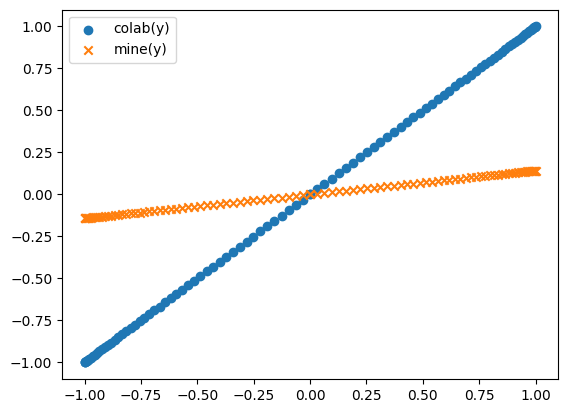

In [328]:
test_ind = 5
test_alpha  = alpha.reshape(-1,1,1)[test_ind,0].item()
test_input = test_alpha*data[0,:,0]
## testing y 
plt.scatter(data[0,:,1],frames[5,:,1])
plt.scatter(data[0,:,1],warp(data, 1, 0, eps=1e-5)[:,1], marker = 'x')

## testing x 
# plt.scatter(data[0,:,0],frames[5,:,0])
# plt.scatter(data[0,:,0],-warp(data, test_alpha, 0, eps=1e-5)[:,0], marker = 'x')
plt.legend(["colab(y)","mine(y)"])
# plt.legend(["colab(x)","mine(x)"])

In [158]:
(test_input-test_input.mean())/t.sqrt(test_input.var() + eps)

tensor([ 1.3820,  1.3792,  1.3708,  1.3568,  1.3372,  1.3123,  1.2820,  1.2465,
         1.2059,  1.1604,  1.1102,  1.0554,  0.9963,  0.9332,  0.8663,  0.7958,
         0.7220,  0.6453,  0.5659,  0.4842,  0.4005,  0.3151,  0.2284,  0.1408,
         0.0525, -0.0361, -0.1246, -0.2126, -0.2999, -0.3859, -0.4705, -0.5533,
        -0.6339, -0.7119, -0.7872, -0.8594, -0.9281, -0.9932, -1.0543, -1.1113,
        -1.1638, -1.2117, -1.2547, -1.2928, -1.3257, -1.3534, -1.3756, -1.3924,
        -1.4036, -1.4092, -1.4092, -1.4036, -1.3924, -1.3756, -1.3534, -1.3257,
        -1.2928, -1.2547, -1.2117, -1.1638, -1.1113, -1.0543, -0.9932, -0.9281,
        -0.8594, -0.7872, -0.7119, -0.6339, -0.5533, -0.4705, -0.3859, -0.2999,
        -0.2126, -0.1246, -0.0361,  0.0525,  0.1408,  0.2284,  0.3151,  0.4005,
         0.4842,  0.5659,  0.6453,  0.7220,  0.7958,  0.8663,  0.9332,  0.9963,
         1.0554,  1.1102,  1.1604,  1.2059,  1.2465,  1.2820,  1.3123,  1.3372,
         1.3568,  1.3708,  1.3792,  1.38